# GeekBrains Credit Default Classification Course Project 2020-09-17

## Установка библиотек (если отсутствуют)

In [1]:
# %conda install --file requirements.txt

# Подключение библиотек и скриптов

In [2]:
import datetime
import os
import pickle

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

import catboost as ctb
import sklearn
# 1. Dataset splitting and cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
# 2. Scaling
from sklearn.preprocessing import StandardScaler
# 3. Metrics
from sklearn.metrics import classification_report, accuracy_score, f1_score

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

**Скрипт для уменьшения занимаемой памяти DataFrame**

In [4]:
def reduce_mem_usage(df, *, verbose=False):
    """ Iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
        From Kaggle Notebook:
        https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    """
    if verbose:
        start_mem = df.memory_usage().sum() / 1024**2
        print(f"Memory usage of dataframe is {start_mem:.2f} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    if verbose:
        end_mem = df.memory_usage().sum() / 1024**2
        mem_decrease_percent = 100 * (start_mem - end_mem) / start_mem
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
        print(f"Decreased by {mem_decrease_percent:.1f}%")
    
    return df

**Скрипт визуализации диаграммы распределения вероятности**

In [5]:
def plot_dist_with_stats(series: pd.Series, *, var_name: str='Variable', bins: int=30, log=False):
    """Visualize numeric variable distribution."""
    plt.figure(figsize=(12, 6))
    
    distplot = sns.distplot(series, bins=bins, fit=norm,
                            hist_kws={'ec': 'white', 'log': log}, 
                            fit_kws={'label': 'Normal Distribution'})
    
    # Plotting the 3 averages
    tallest_bin_height = max([b.get_height() for b in distplot.patches])
    y = [0, tallest_bin_height]
    # Mean
    plt.plot([series.mean()] * len(y), y, color='green', linestyle='dashed', label='mean')
    # Median
    plt.plot([series.median()] * len(y), y, color='blue', linestyle='dashed', label='median')
    # Mode (adjusted)
    var_bin_count = len(series) // 100
    var_bin_range = (series.max() - series.min()) / var_bin_count
    var_bins = series // var_bin_range * var_bin_range
    adjusted_mode = var_bins.mode()[0]
    plt.plot([adjusted_mode] * len(y), y, color='red', linestyle='dashed', label='adjusted mode')

    plt.legend(loc='upper right')
    plt.title(f"Distribution of {var_name}")
    
    plt.show()

**Скрипт визуализации частоты значений переменной**

In [6]:
def plot_bar_frequency(series: pd.Series, *, show_labels=False, log=False):
    """Visualize discrete, low-cardinality variable distribution."""
    freq = series.value_counts()
    
    fig, ax = plt.subplots()
    ax.bar(freq.index, freq, log=log)
    
    ax.set_title(f"{'Log ' if log else ''}{series.name}")
    ax.set_ylabel('Frequency')
    
    if show_labels:
        for i, patch in enumerate(ax.patches):
            width = patch.get_x() + patch.get_width() / 2
            height = patch.get_height() + 5
            ax.annotate(freq[i],
                        (width, height),
                        ha='center',
                        va='bottom')
        
    return ax

In [7]:
def undersample(X, target_name):
    """ Undersample the DataFrame.
        Modified from example taken from GeekBrains Balancing webinar.
    """
    X = X.copy()
        
    target_counts = X[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    tmp = X[X[target_name] == major_class_name]
    X = X[X[target_name] == minor_class_name]
    X = X.append(tmp.iloc[np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
                           ], ignore_index=True)

    return X.sample(frac=1) 

**Скрипт для логирования каждой тренировки, оценки и кросс-валидации модели**

In [8]:
def log_model_results(model:sklearn.base.BaseEstimator,
                      accuracy:np.float64 = None,
                      f1_score:np.float64 = None,
                      cv_score:np.float64 = None,
                      comment:str = None,
                      train_log_path:str = "./training_log.csv",
                      *args, **kwargs) -> None:
    """ Function for logging trained model results on Credit Default dataset.
    Arguments:
        model - a Scikit-learn model that was trained,
        f1_score - F1 score calculated for the model on the training part of the train dataset,
        cv_score - cross-validation F1 score calculated for the model on the full train dataset,
        comment - a comment message for this model training,
        train_log_path - filepath for the training log of the models
    
    Returns:
        None
    """
    
    model_name = type(model).__name__
    model_params = repr(model.get_params())
    curr_datetime = datetime.datetime.now()
    date = curr_datetime.date()
    # Microseconds are not needed
    time = curr_datetime.time().replace(microsecond=0)
    
    log_string = f"{date};{time};{model_name};{accuracy if accuracy else ''};" + \
                 f"{f1_score if f1_score else ''};{cv_score if cv_score else ''};{model_params};" + \
                 f"{comment if comment else ''}\n"
    
    # Setup the log file if it's not created or is blank
    if not os.path.isfile(train_log_path):
        with open(train_log_path, 'w', encoding='utf-8'):
            pass
    if os.stat(train_log_path).st_size == 0:
        with open(train_log_path, 'w', encoding='utf-8') as file:
            file.write(f"date;time;model_type;accuracy;f1;cv_f1;hypers;comment\n")
    
    with open(train_log_path, 'a', encoding='utf-8') as file:
        file.write(log_string)
        print(log_string)

**Скрипт визуализации предсказаний модели**

In [9]:
def eval_predictions(model, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series) -> None:
    """ Display all metrics for a trained classification model.
        Taken from GeekBrains webinar notebook.
    """
    
    def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
        """ Get classification reports for train and test parts of datasets + confusion matrix.
            Taken from GeekBrains webinar notebook.
        """
        print('Train\n\n' + classification_report(y_train_true, y_train_pred))
        print('Test\n\n' + classification_report(y_test_true, y_test_pred))
        print('Confusion Matrix\n')
        print(pd.crosstab(y_test_true, y_test_pred))
    

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

**Пути к файлам**

In [10]:
TRAIN_FILEPATH = './data/train.csv'
PREPARED_TRAIN_FILEPATH = './data/prepared_train.csv'
TEST_FILEPATH = './data/test.csv'
SCALER_FILEPATH = './scaler.pkl'
MODEL_FILEPATH = './model.pkl'
LOGFILE_FILEPATH = './training_log.csv'

# Загрузка данных в DataFrame

**Описание задачи**

Цель - предсказать, сможет ли человек выполнить свои кредитные обязательства.\
Тренировка модели классификации будет проходить на датасете course_project_train.csv с имеющимися целевыми значениями.\
Модель будет предсказывать результаты для датасета course_project_test.csv.

Эта цель может быть полезна для:
* банков и кредитных организаций, выдающих кредиты.

**Описание датасета**

В датасете описаны люди, взявшие кредиты, с различной информацией об их финансовом состоянии (признаки) и целевой переменной - факт невыполнения обязательств по кредиту Credit Default.\
Датасет является табличными, структурированными данными.

Признаки датасета:
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [11]:
train_df = pd.read_csv(TRAIN_FILEPATH, sep=',')
train_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


In [12]:
test_df = pd.read_csv(TEST_FILEPATH, sep=',')
test_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


Количество наблюдений в датасете.

In [13]:
print(f"Train samples: {train_df.shape[0]}")
print(f"Test samples: {test_df.shape[0]}")

Train samples: 7500
Test samples: 2500


Количество признаков в датасете (вместе с целевой переменной Price).

In [14]:
train_df.shape[1]

17

Проверяем, что в train и test одинаковое количество признаков.

In [15]:
train_df.shape[1] - 1 == test_df.shape[1]

True

**Уменьшаем занимаемую память DataFrame**

In [16]:
train_df = reduce_mem_usage(train_df, verbose=True)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


**Типы данных переменных**

In [17]:
train_df.dtypes

Home Ownership                  category
Annual Income                    float32
Years in current job            category
Tax Liens                        float32
Number of Open Accounts          float32
Years of Credit History          float32
Maximum Open Credit              float32
Number of Credit Problems        float32
Months since last delinquent     float32
Bankruptcies                     float32
Purpose                         category
Term                            category
Current Loan Amount              float32
Current Credit Balance           float32
Monthly Debt                     float32
Credit Score                     float32
Credit Default                      int8
dtype: object

# 1. EDA и Preprocessing

## 1.1. Анализ таргета Credit Default

In [18]:
target = 'Credit Default'

In [19]:
train_df[target].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Классы несбалансированны.

## 1.2. Анализ признаков датасета

### 1.2.1. Вещественные признаки

In [20]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130934,18.317467,9.451538e+05,0.170000,34.692600,0.117152,11873178.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688807,0.347192,31926124.0,3.178714e+05,11926.764648,1604.451416,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.000000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.000000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


Замеченные выбросы:
* Annual Income - max 10 000 000 выглядит многовато, но возможно в пределах нормы.
* Maximum Open Credit - max 1 304 000 000 значительно больше, все остальные статистики. Похоже, что лишние 3 нуля.\
* Current Loan Amount - max 100 000 000 также значительно больше остальных статистик. Лишние 2 нуля?\
* Credit Score - max 7510. Больше 1000 кредитный рейтинг не бывает. Этот выброс также тянет за собой медиану и стандартное отклонение.

### Annual Income

In [21]:
train_df['Annual Income'].value_counts()

1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64

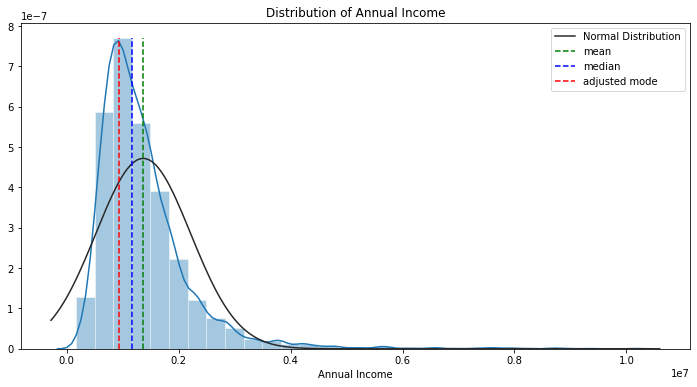

In [22]:
plot_dist_with_stats(train_df['Annual Income'], var_name='Annual Income')

В целом, такое распределение довольно нормально для годового дохода, можно оставить все, как есть.

### Tax Liens

In [23]:
train_df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

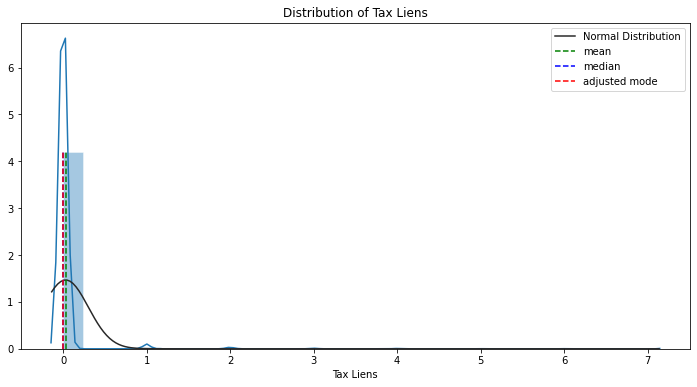

In [24]:
plot_dist_with_stats(train_df['Tax Liens'], var_name='Tax Liens')

Большинство значений признака в датасете - 0.\
Стоит рассмотреть объединение ненулевых значений признака.

### Number of Open Accounts

In [25]:
train_df['Number of Open Accounts'].value_counts()

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
35.0      1
41.0      1
38.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64

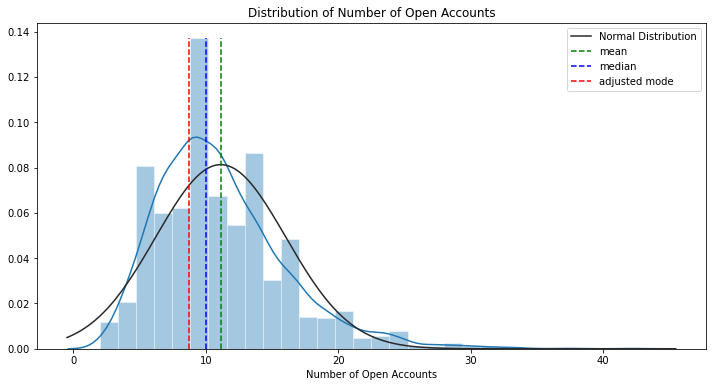

In [26]:
plot_dist_with_stats(train_df['Number of Open Accounts'], var_name='Number of Open Accounts')

### Years of Credit History

In [27]:
train_df['Years of Credit History'].value_counts()

15.000000    104
16.000000     99
16.500000     91
17.000000     86
17.500000     83
            ... 
40.099998      1
39.500000      1
50.900002      1
44.299999      1
38.500000      1
Name: Years of Credit History, Length: 408, dtype: int64

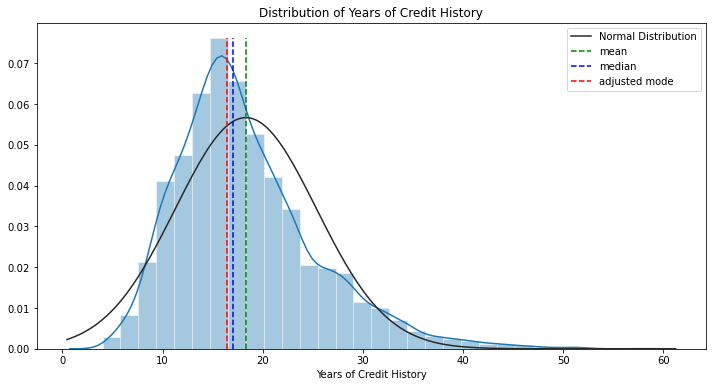

In [28]:
plot_dist_with_stats(train_df['Years of Credit History'], var_name='Years of Credit History')

### Maximum Open Credit

In [29]:
train_df['Maximum Open Credit'].value_counts()

0.0          65
319110.0      5
334796.0      3
607046.0      3
294030.0      3
             ..
534600.0      1
1026124.0     1
77066.0       1
780164.0      1
350768.0      1
Name: Maximum Open Credit, Length: 6963, dtype: int64

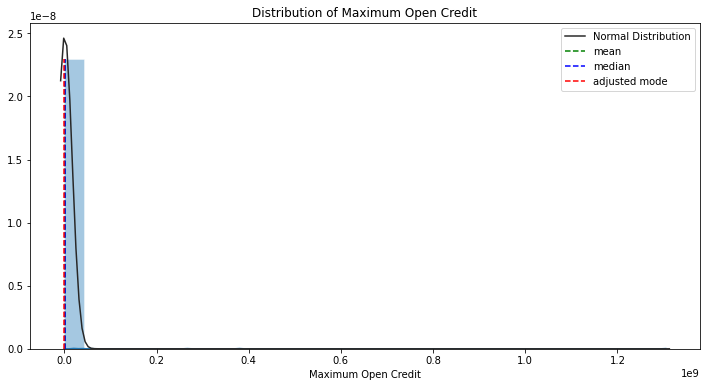

In [30]:
plot_dist_with_stats(train_df['Maximum Open Credit'], var_name='Maximum Open Credit')

Посмотрим, какие именно значения являются значительными выбросами.

In [31]:
train_df['Maximum Open Credit'].value_counts().sort_index(ascending=False).head(10)

1.304726e+09    1
3.800523e+08    1
2.655129e+08    1
5.756256e+07    1
4.092390e+07    1
2.640700e+07    1
2.634333e+07    1
2.137243e+07    1
1.928043e+07    1
1.868381e+07    1
Name: Maximum Open Credit, dtype: int64

Ограничимся 99.5-м квантилем.

In [32]:
max_open_cred_max = train_df['Maximum Open Credit'].quantile(0.995)
max_open_cred_max

6207624.060000005

In [33]:
train_df.loc[train_df['Maximum Open Credit'] > max_open_cred_max, 'Maximum Open Credit'].count()

38

38 значений больше 6 200 000.

Посмотрим на распределение без сильных выбросов (< 6 200 000).

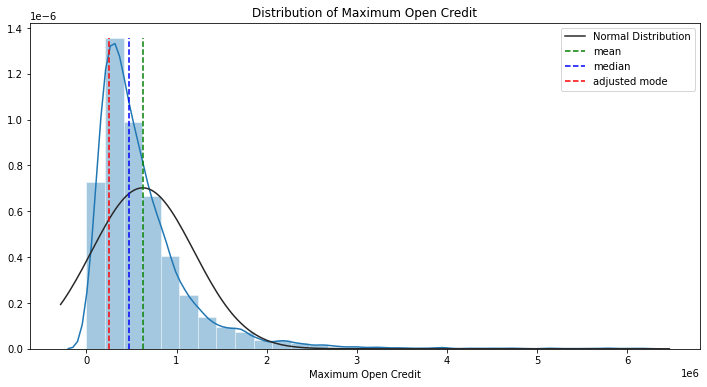

In [34]:
plot_dist_with_stats(train_df.loc[train_df['Maximum Open Credit'] < max_open_cred_max, 'Maximum Open Credit'], var_name='Maximum Open Credit')

### Number of Credit Problems

In [35]:
train_df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

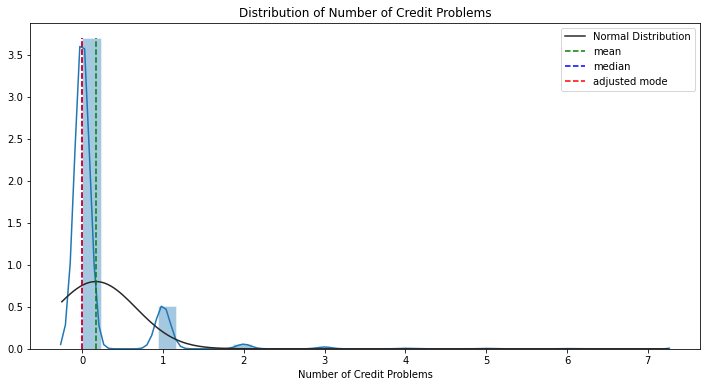

In [36]:
plot_dist_with_stats(train_df['Number of Credit Problems'], var_name='Number of Credit Problems')

Большинство значений признака в датасете - 0.\
Стоит рассмотреть объединение ненулевых значений признака.

### Months since last delinquent

In [37]:
train_df['Months since last delinquent'].value_counts()

14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
         ..
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

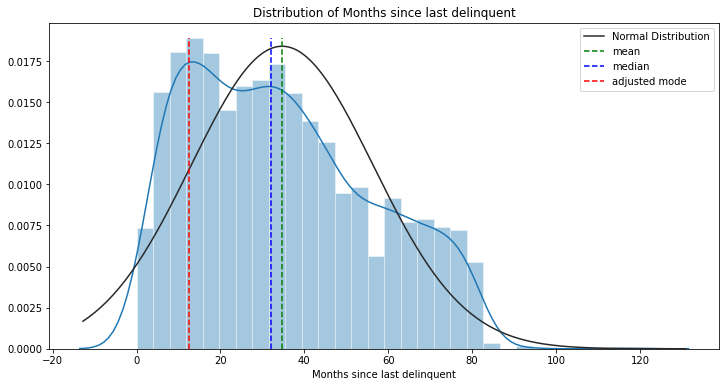

In [38]:
plot_dist_with_stats(train_df['Months since last delinquent'], var_name='Months since last delinquent')

### Bankruptcies

In [39]:
train_df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

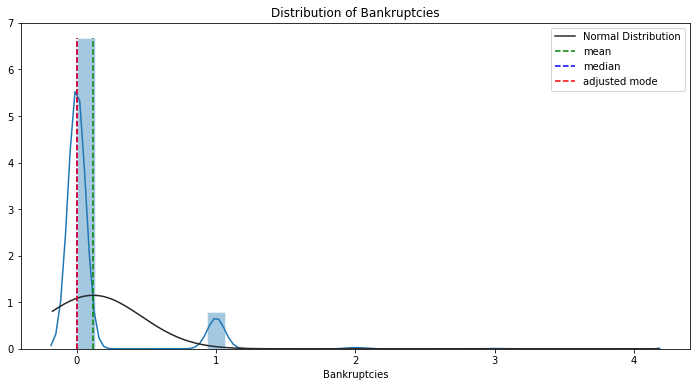

In [40]:
plot_dist_with_stats(train_df['Bankruptcies'], var_name='Bankruptcies')

Большинство значений признака в датасете - 0.\
Стоит рассмотреть объединение ненулевых значений признака.

### Current Loan Amount

In [41]:
train_df['Current Loan Amount'].value_counts()

100000000.0    870
89298.0          6
218064.0         6
216106.0         5
270226.0         5
              ... 
490006.0         1
404756.0         1
194414.0         1
420376.0         1
33792.0          1
Name: Current Loan Amount, Length: 5386, dtype: int64

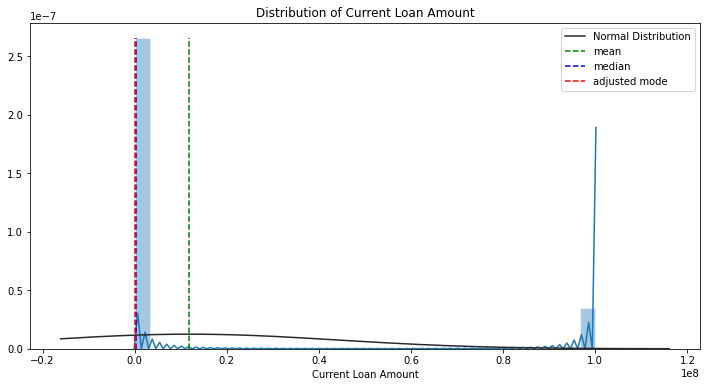

In [42]:
plot_dist_with_stats(train_df['Current Loan Amount'], var_name='Current Loan Amount')

In [43]:
train_df['Current Loan Amount'].value_counts().sort_index(ascending=False)

100000000.0    870
789030.0         1
788942.0         1
788788.0         1
788634.0         2
              ... 
21582.0          1
21560.0          1
21516.0          1
21472.0          2
11242.0          1
Name: Current Loan Amount, Length: 5386, dtype: int64

870 (11.6%) значений просто равны 100 000 000.

Посмотрим на распределение без этих выбросов (< 100 000 000).

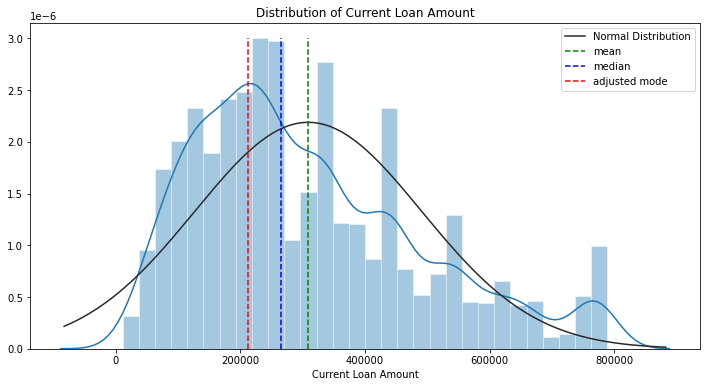

In [44]:
plot_dist_with_stats(train_df.loc[train_df['Current Loan Amount'] < 1 * 10**8, 'Current Loan Amount'], var_name='Current Loan Amount')

### Current Credit Balance

In [45]:
train_df['Current Credit Balance'].value_counts()

0.0         53
191710.0     5
53580.0      4
106818.0     4
155059.0     4
            ..
229672.0     1
349467.0     1
116223.0     1
797240.0     1
189905.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64

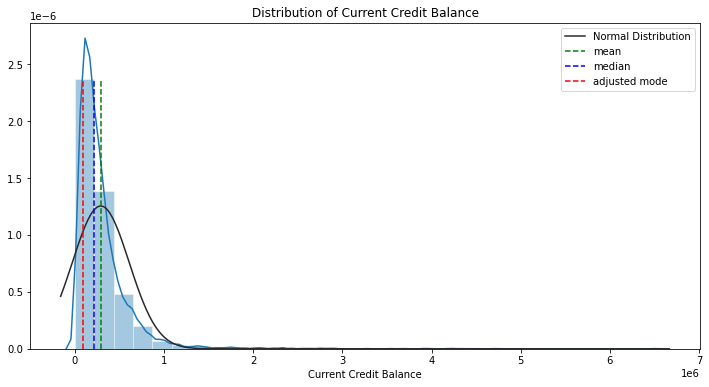

In [46]:
plot_dist_with_stats(train_df['Current Credit Balance'], var_name='Current Credit Balance')

В целом, такое распределение довольно нормально для текущего кредитного баланса, можно оставить все, как есть.

### Monthly Debt

In [47]:
train_df['Monthly Debt'].value_counts()

0.0        6
19222.0    4
19667.0    4
9525.0     3
22364.0    3
          ..
12897.0    1
27541.0    1
23227.0    1
55957.0    1
17.0       1
Name: Monthly Debt, Length: 6716, dtype: int64

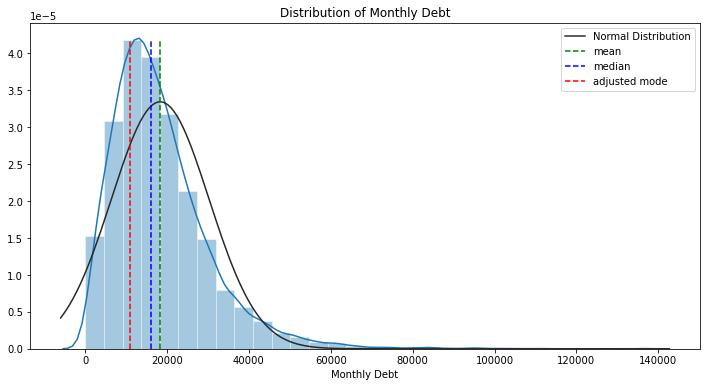

In [48]:
plot_dist_with_stats(train_df['Monthly Debt'], var_name='Monthly Debt')

### Credit Score

In [49]:
train_df['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
741.0     151
         ... 
602.0       1
616.0       1
585.0       1
620.0       1
7010.0      1
Name: Credit Score, Length: 268, dtype: int64

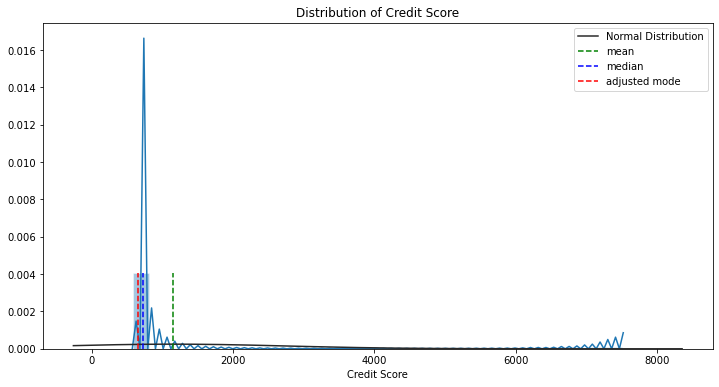

In [50]:
plot_dist_with_stats(train_df['Credit Score'], var_name='Credit Score')

In [51]:
train_df.loc[train_df['Credit Score'] > 850, 'Credit Score'].count()

400

400 (5.33%) значений больше 850 (максимум кредитного рейтинга), что невозможно для кредитного рейтинга.

Посмотрим на эти значения подробнее.

In [52]:
train_df.loc[train_df['Credit Score'] > 850, 'Credit Default'].sum()

400

In [53]:
train_df[train_df['Credit Score'] > 850].sample(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4846,Own Home,973370.0,3 years,0.0,23.0,28.799999,1639660.0,0.0,NaN,0.0,debt consolidation,Long Term,338030.0,955852.0,27741.0,7000.0,1
2515,Rent,742805.0,5 years,0.0,5.0,16.299999,160336.0,0.0,53.0,0.0,debt consolidation,Long Term,175758.0,131822.0,8598.0,6780.0,1
3280,Home Mortgage,1135098.0,< 1 year,0.0,10.0,11.000000,288332.0,0.0,NaN,0.0,other,Long Term,350482.0,21413.0,6432.0,7240.0,1
4270,Rent,774820.0,< 1 year,0.0,11.0,12.700000,311652.0,0.0,NaN,0.0,debt consolidation,Short Term,134574.0,187872.0,4378.0,7300.0,1
6355,Home Mortgage,1447667.0,10+ years,0.0,10.0,20.400000,299530.0,0.0,NaN,0.0,home improvements,Long Term,446996.0,72694.0,7202.0,6640.0,1
3055,Rent,742292.0,10+ years,0.0,6.0,34.299999,135300.0,0.0,41.0,0.0,debt consolidation,Short Term,235818.0,88806.0,10330.0,7190.0,1
4049,Home Mortgage,1152996.0,8 years,0.0,10.0,12.900000,271480.0,0.0,48.0,0.0,debt consolidation,Long Term,467258.0,138567.0,27095.0,7170.0,1
2383,Home Mortgage,967290.0,6 years,0.0,10.0,11.400000,859628.0,0.0,37.0,0.0,debt consolidation,Short Term,498410.0,266532.0,21925.0,7120.0,1
3883,Home Mortgage,1164168.0,10+ years,0.0,10.0,16.299999,424512.0,0.0,36.0,0.0,debt consolidation,Long Term,359458.0,161310.0,21149.0,7190.0,1
2420,Rent,3113568.0,1 year,0.0,17.0,19.400000,2347378.0,0.0,78.0,0.0,debt consolidation,Short Term,788634.0,810901.0,60455.0,7180.0,1


Как можно увидеть, абсолютно все значения выбросов выше 850 содержат 1 в таргете Credit Default, то есть они не выполнили свои кредитные обязательства.

Проверим также возможные значения признака ниже 300 (минимум кредитного рейтинга).

In [54]:
train_df.loc[train_df['Credit Score'] < 300, 'Credit Score'].count()

0

Нет значений меньше 300.

Посмотрим на распределение без сильных выбросов (< 1000).

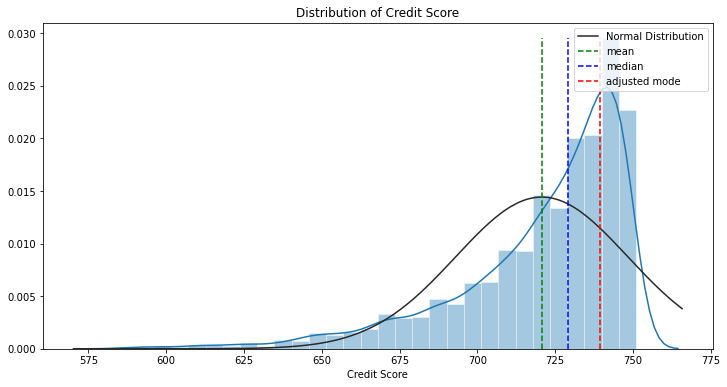

In [55]:
plot_dist_with_stats(train_df.loc[train_df['Credit Score'] <= 850, 'Credit Score'], var_name='Credit Score')

Распределение похоже на экспоненциальное.

### 1.2.2. Категориальные признаки

In [56]:
for feature in train_df.select_dtypes(include='category').columns:
    print(f"{feature}\n\n{train_df[feature].value_counts()}")
    print('-' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
----------------------------------------------------------------------------------------------------

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
----------------------------------------------------------------------------------------------------

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

Для признака Home Ownership есть 12 наблюдений с категорией "Have Mortgage".\
По сути это очень похоже на "Home Mortgage".\
Стоит проверить эти значения и, возможно, объединить их.

У признака Purpose есть много категорий, для которых мало наблюдений.\
Стоит также рассмотреть объединение некоторых признаков по логичным категориями, вроде "consumer expenses".

Признаки Years in current job и Term вполне можно перевести в числовые.\
Для Term подойдут просто значения 0 и 1.\
Для Years in current job, можно заменить категории на соответствующее количество полных лет стажа.\
Категорию "< 1 year" можно заменить числом 0, а категорию "10+ years" просто числом 10.\
Это будет означать, что значение 10 ставится для любого стажа на текущей работе, который 10 лет или более.

## 1.3. Обработка пропущенных значений

In [57]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

### Annual Income

In [58]:
ann_inc_median = train_df['Annual Income'].median()

In [59]:
train_df['Annual Income'] = train_df['Annual Income'].fillna(ann_inc_median)

### Years in current job

Возможно значения признака отсутствовали, т.к. у этих людей нет текущей работы, нет вообще опыта работы или же у них собственный бизнес.\
Поставим это значение как < 1 year.

In [60]:
train_df['Years in current job'] = train_df['Years in current job'].fillna('< 1 year')

### Months since last delinquent

4081 пропущенное значение из 7500 - слишком большая доля пропусков.\
Удалим этот признак.

In [61]:
train_df = train_df.drop(columns=['Months since last delinquent'])

### Bankruptcies

In [62]:
train_df['Bankruptcies'] = train_df['Bankruptcies'].fillna(0)

### Credit Score

In [63]:
cred_score_median = train_df['Credit Score'].median()
cred_score_median

731.0

In [64]:
train_df['Credit Score'] = train_df['Credit Score'].fillna(cred_score_median)

## 1.4. Обработка выбросов

### Annual Income

In [65]:
train_df.loc[train_df['Annual Income'] > 4 * 10**6, 'Annual Income'] = ann_inc_median

### Maximum Open Credit

In [66]:
train_df.loc[train_df['Maximum Open Credit'] > max_open_cred_max, 'Maximum Open Credit'] = max_open_cred_max

### Current Loan Amount

Приравняем все значения 100 000 000 к максимальному значению признака за исключением этого значения.

In [67]:
curr_loan_max = train_df.loc[train_df['Current Loan Amount'] < 1 * 10**8, 'Current Loan Amount'].max()
curr_loan_max

789030.0

In [68]:
train_df.loc[train_df['Current Loan Amount'] == 1 * 10**8, 'Current Loan Amount'] = curr_loan_max

### Credit Score

In [69]:
train_df.loc[train_df['Credit Score'] > 850, 'Credit Score'].describe()

count     400.000000
mean     7115.100098
std       306.745361
min      6060.000000
25%      6987.500000
50%      7190.000000
75%      7340.000000
max      7510.000000
Name: Credit Score, dtype: float64

400 выбросов со значениями в диапазоне [6060.0; 7510.0].\
Все похожи на то, что имеют лишний 0 на конце.\
Пока что оставим эти значения, как есть, так как их обработка значительно ухудшает модель.

In [70]:
# Поделим все выбросы >= 3000 на 10 (начало кредитного рейтинга - 300 очков).
train_df.loc[train_df['Credit Score'] >= 3000, 'Credit Score'] //= 10

In [71]:
# Удалим все выбросы >= 3000.
# train_df = train_df.drop(train_df[train_df['Credit Score'] >= 3000].index)

In [72]:
(train_df['Credit Score'] > 850).sum()

0

## 1.5. Зависимости между признаками, таргетом

### Корреляция переменных

In [73]:
train_corr = train_df.corr()

In [74]:
train_corr['Credit Default'].sort_values(ascending=False)

Credit Default               1.000000
Number of Open Accounts      0.028884
Tax Liens                    0.024368
Number of Credit Problems    0.020088
Monthly Debt                 0.018480
Bankruptcies                 0.001640
Current Credit Balance      -0.019522
Years of Credit History     -0.020567
Maximum Open Credit         -0.067338
Annual Income               -0.092653
Current Loan Amount         -0.103525
Credit Score                -0.166884
Name: Credit Default, dtype: float64

<AxesSubplot:>

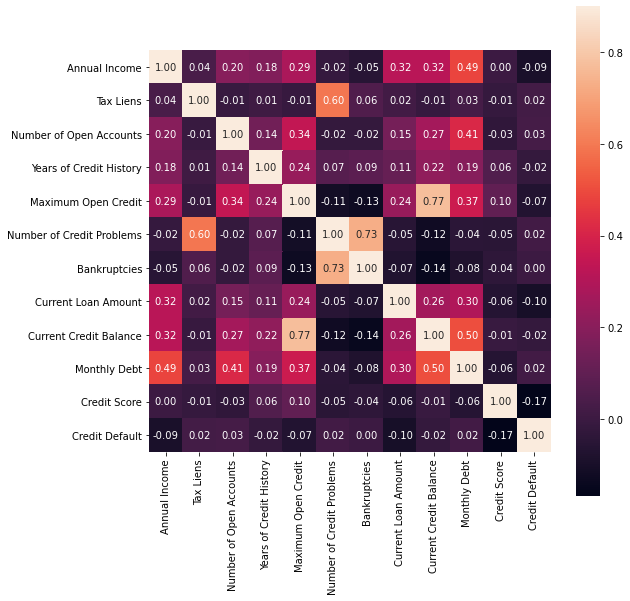

In [75]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(train_corr, vmax=0.9, annot=True, square=True, fmt='.2f')

* Признак Credit Score показывает наибольшую корреляцию с Credit Default из вещественных признаков - 0.38. Это странно, так как более высокий рейтинг должен означать большее доверие к клиенту по выплате кредита. Так получилось из-за выбросов Credit Score в диапазоне [6000, 7500], во всех этих наблюдениях кредитные обязательства не были выполнены (Credit Default == 1). Но эти выбросы улучшают метрики модели.
* Признак Number of Credit Problems сильно коррелируют с Bankruptcies и Tax Liens (немного слабее).
* Признаки Maximum Open Credit и Current Credit Balance сильно коррелируют.
* Признак Monthly Debt средне коррелирует с Annual Income и Current Credit Balance.
* У людей с большим Annual Income обычно выше кредитный лимит, но также и больше долги.
* В общем, на Credit Default положительно влияют Tax Liens, Number of Open Accounts, Number of Credit Problems, Monthly Debt. Это логично, эти признаки обычно являются индикаторами того, что человеку сложно выплатить кредит.
* Напротив, Annual Income, Years of Credit History, Maximum Open Credit, Current Loan Amount, Current Credit Balance негативно влияют на Credit Default. Это логично, ведь это индикаторы доверия к клиенту - чем больше он зарабатывает и чем лучше его история - тем больше вероятность, что клиент вернет кредит. Это верно даже при том, что более состоятельные люди обычно берут бОльшие по сумме кредиты.

**Парные диаграммы для непрерывных признаков**

In [76]:
continuous_vars = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
                   'Current Loan Amount', 'Current Credit Balance', 'Credit Score']

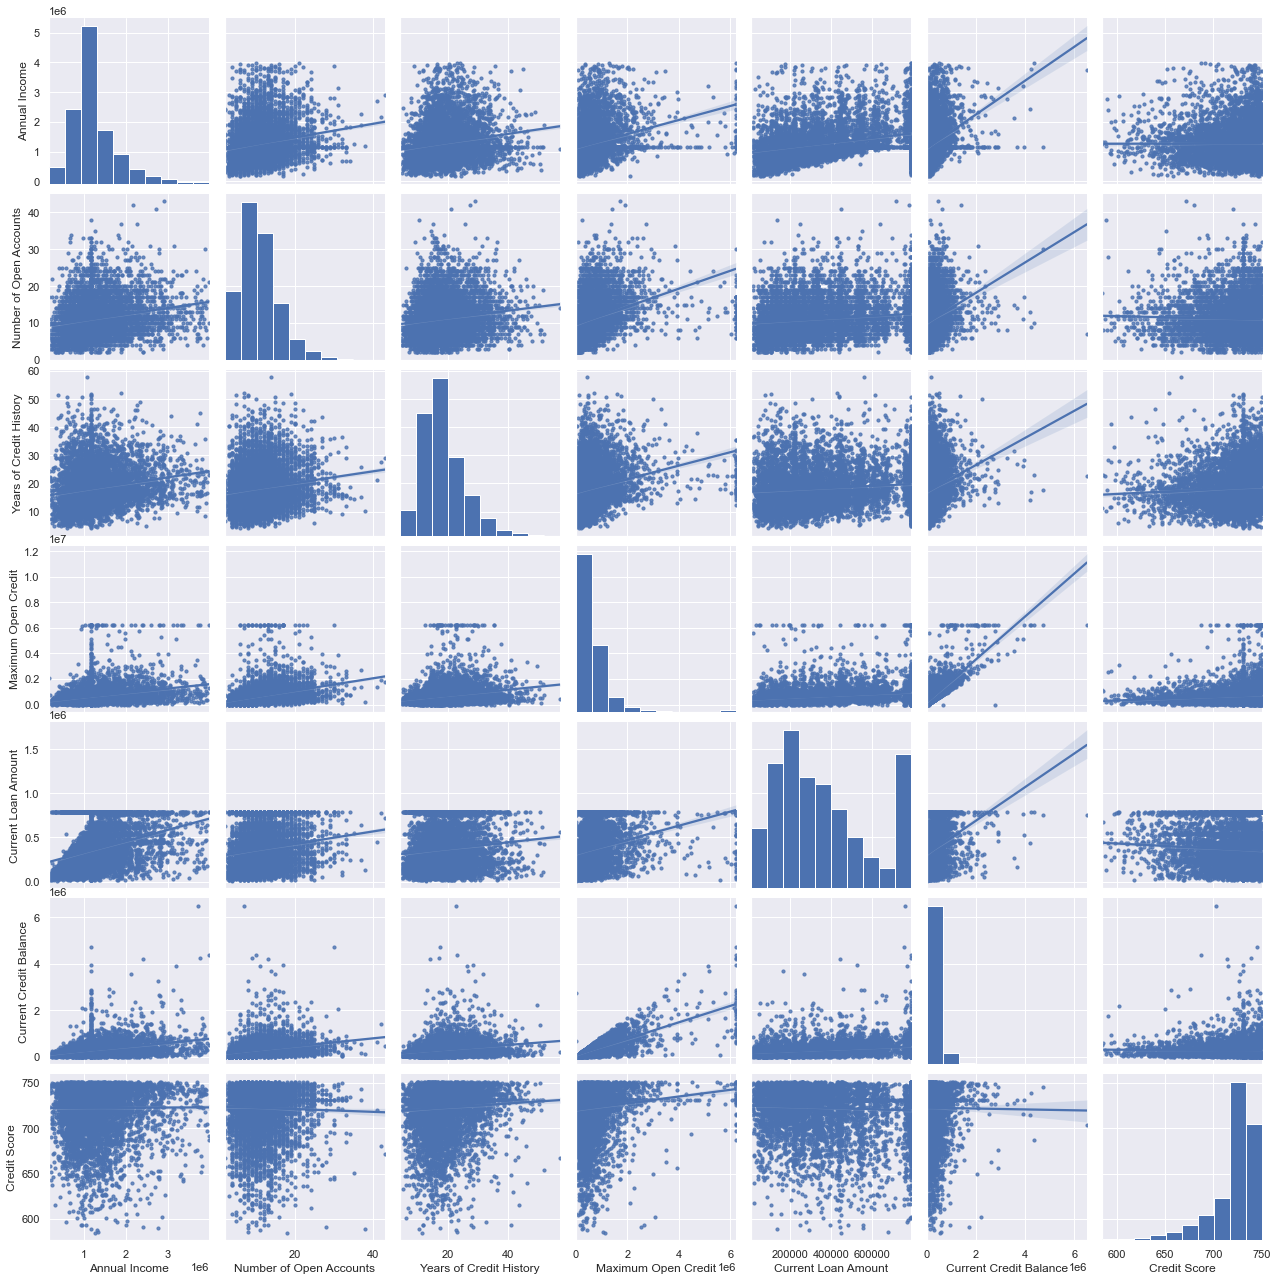

In [77]:
sns.set()
sns.pairplot(train_df[continuous_vars],
             height=2.5,
             kind='reg',
             plot_kws={'scatter_kws': {'s': 10}})

Можно заметить, что у многих непрерывных признаков распределение похоже на логарифмически нормальное.

### Категориальные признаки

In [78]:
pd.crosstab(train_df['Credit Default'], train_df['Tax Liens'])

Tax Liens,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
Credit Default,,,,,,,,
0,5301,59,15,5,3,1,2,1
1,2065,24,15,5,3,1,0,0


In [79]:
for i, feature in enumerate(train_df.select_dtypes(include='category').columns):
    print(pd.crosstab(train_df[feature], train_df['Credit Default']))
    print('-' * 100)

Credit Default     0     1
Home Ownership            
Have Mortgage     10     2
Home Mortgage   2721   916
Own Home         455   192
Rent            2201  1003
----------------------------------------------------------------------------------------------------
Credit Default           0    1
Years in current job           
1 year                 362  142
10+ years             1688  644
2 years                512  193
3 years                450  170
4 years                338  131
5 years                371  145
6 years                302  124
7 years                285  111
8 years                247   92
9 years                194   65
< 1 year               638  296
----------------------------------------------------------------------------------------------------
Credit Default           0     1
Purpose                         
business loan           74    55
buy a car               72    24
buy house               25     9
debt consolidation    4290  1654
educational expenses  

## 1.6. Трансформация переменных

### Term

Заменим 2 категории на бинарный количественный признак.

In [80]:
train_df['Term'] = pd.Series(train_df['Term'].map({'Short Term': 0, 'Long Term': 1}), dtype=np.int8)

In [81]:
train_df['Term'].head()

0    0
1    1
2    0
3    0
4    0
Name: Term, dtype: int8

### Years in current job

Заменим категории на соответствующее количество полных лет стажа.\
Категорию "10+ years" заменяем на 10 полных лет стажа, это будет максимальным значением.

In [82]:
job_years_dict = {'< 1 year': 0,
                  '1 year': 1,
                  '2 years': 2,
                  '3 years': 3,
                  '4 years': 4,
                  '5 years': 5,
                  '6 years': 6,
                  '7 years': 7,
                  '8 years': 8,
                  '9 years': 9,
                  '10+ years': 10}
train_df['Years in current job'] = pd.Series(train_df['Years in current job'].map(job_years_dict), dtype=np.int8)

In [83]:
train_df['Years in current job'].head()

0     0
1    10
2     8
3     6
4     8
Name: Years in current job, dtype: int8

### Объединение значений

Не успел поработать с этим и вообще с критериями, к сожалению :(

## 1.7. Генерация новых признаков

**No Tax Liens - True, если Tax Liens == 0, иначе False**

In [84]:
train_df['No Tax Liens'] = (train_df['Tax Liens'] == 0)

**No Credit Problems - True, если Number of Credit Problems == 0, иначе False**

In [85]:
train_df['No Credit Problems'] = (train_df['Number of Credit Problems'] == 0)

**No Bankruptcies - True, если Bankruptcies == 0, иначе False**

In [86]:
train_df['No Bankruptcies'] = (train_df['Bankruptcies'] == 0)

**Credit Score Tier - уровень того, насколько хорош Credit Score**

* 0 - poor (300-579),
* 1 - fair (580-669),
* 2 - good(670-739),
* 3 - very good(740-799),
* 4 - exceptional(800-850),
* -1 - other

In [87]:
train_df['Credit Score Tier'] = 0
train_df.loc[(train_df['Credit Score'] >= 580) & (train_df['Credit Score'] < 670), 'Credit Score Tier'] = 1
train_df.loc[(train_df['Credit Score'] >= 670) & (train_df['Credit Score'] < 740), 'Credit Score Tier'] = 2
train_df.loc[(train_df['Credit Score'] >= 740) & (train_df['Credit Score'] < 800), 'Credit Score Tier'] = 3
train_df.loc[(train_df['Credit Score'] >= 800) & (train_df['Credit Score'] <= 850), 'Credit Score Tier'] = 4
train_df.loc[train_df['Credit Score'] > 850, 'Credit Score Tier'] = -1

## 1.8. Отбор признаков

In [88]:
train_df.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'No Tax Liens',
 'No Credit Problems',
 'No Bankruptcies',
 'Credit Score Tier']

In [89]:
features = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 
            'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
            'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 
            'Current Credit Balance', 'Monthly Debt', 'Credit Score']

In [90]:
new_features = ['No Tax Liens', 'No Credit Problems', 'No Bankruptcies', 'Credit Score Tier']

In [91]:
target = 'Credit Default'

In [92]:
train_df = train_df[features + new_features + [target]]

## 1.9. Dummy-переменные

In [93]:
train_df = pd.get_dummies(train_df, drop_first=True)

In [94]:
train_df.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
       'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'No Tax Liens', 'No Credit Problems', 'No Bankruptcies',
       'Credit Score Tier', 'Credit Default', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding'],
      dtype='object')

## 1.10. Стандартизация признаков

In [95]:
features_to_standard = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts',
                        'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                        'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
                        'Monthly Debt', 'Credit Score']

In [96]:
scaler = StandardScaler()
standard_features = scaler.fit_transform(train_df[features_to_standard])

In [97]:
train_df[features_to_standard] = pd.DataFrame(standard_features, columns=features_to_standard)
train_df[features_to_standard]

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,-1.379180,-1.489549,-0.110953,-0.026674,1.133645,0.046461,1.664779,2.545732,1.843175,-0.762772,-0.872085,1.054296
1,-0.430770,1.175372,-0.110953,0.788223,-0.428528,0.763515,-0.340979,-0.337099,-0.433236,0.330781,0.004909,0.579521
2,-0.909120,0.642388,-0.110953,-0.026674,2.369181,0.764534,-0.340979,-0.337099,1.843175,0.058379,-0.391034,0.777344
3,-0.815473,0.109404,-0.110953,-0.637847,0.593985,-0.732482,1.664779,2.545732,-1.056881,-0.610282,-0.584980,-1.121756
4,-0.865746,0.642388,-0.110953,0.380774,-0.669954,-0.387622,1.664779,-0.337099,-1.037578,-0.618292,-0.933631,-0.132642
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,-1.518623,-1.489549,-0.110953,-1.656468,-1.394234,-0.789662,-0.340979,-0.337099,-1.022287,-0.680639,-1.376362,-1.003062
7496,0.456723,-1.223057,-0.110953,-0.230398,1.162048,0.046970,-0.340979,-0.337099,0.344648,0.524039,-0.463816,0.737779
7497,1.058732,0.109404,-0.110953,0.177050,1.957336,1.627258,-0.340979,-0.337099,1.843175,0.591407,-0.489306,1.014731
7498,-0.181365,-1.489549,-0.110953,2.010568,1.162048,0.704967,-0.340979,-0.337099,1.088417,0.585907,1.576689,0.342133


## 1.11. Балансировка классов

Экспериментально получилось, что лучше всего сбалансировать классы с помощью undersampling.

In [98]:
train_df = undersample(train_df, target)
train_df[target].value_counts()

1    2113
0    2113
Name: Credit Default, dtype: int64

## 1.12. Описание обработанных данных

In [99]:
train_df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
count,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,...,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000
mean,-0.044243,-0.010726,0.013641,0.007842,-0.005683,-0.038042,0.019260,0.014898,0.303833,-0.048298,...,0.050876,0.004496,0.010648,0.001183,0.091103,0.000473,0.005206,0.004496,0.000947,0.002130
std,0.976704,1.001212,1.029303,1.023919,1.006046,0.954166,1.026542,1.033485,0.459966,0.949308,...,0.219770,0.066909,0.102652,0.034381,0.287789,0.021752,0.071972,0.066909,0.030755,0.046105
min,-1.933304,-1.489549,-0.110953,-1.860192,-2.033305,-0.945673,-0.340979,-0.337099,0.000000,-1.490929,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.626628,-0.956564,-0.110953,-0.637847,-0.684156,-0.553688,-0.340979,-0.337099,0.000000,-0.801154,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.181365,-0.157088,-0.110953,-0.230398,-0.187101,-0.269285,-0.340979,-0.337099,0.000000,-0.266096,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.249822,1.175372,-0.110953,0.584498,0.480373,0.164910,-0.340979,-0.337099,1.000000,0.499222,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.756073,1.175372,21.981543,6.492500,5.592937,8.032690,11.693569,11.194225,1.000000,1.843175,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 2. Классы генерации признаков и предобработки данных

## 2.1. Класс генерации признаков

In [100]:
class FeatureGenerator:
    """Class for generating new features for the Credit Default dataset."""
    def __init__(self):
        """No init or state variables needed, placeholder."""
        pass
    
    def fit(self, X, y=None):
        """No fitting needed, placeholder."""
        pass
    
    def transform(self, X):
        """Generate new features."""
        # Tax Liens has many 0's - feature No Tax Liens - True/False
        X['No Tax Liens'] = (X['Tax Liens'] == 0)
        # Number of Credit Problems has many 0's - feature No Credit Problems - True/False
        X['No Credit Problems'] = (X['Number of Credit Problems'] == 0)
        # Bankruptcies has many 0's - feature No Bankruptcies - True/False
        X['No Bankruptcies'] = (X['Bankruptcies'] == 0)
        
        # Credit Score Tier - how good a Credit Score is
        # 0 - poor (300-579), 1 - fair (580-669), 2 - good(670-739), 3 - very good(740-799), 4 - exceptional(800-850), -1 - other
        X['Credit Score Tier'] = 0
        X.loc[(X['Credit Score'] >= 580) & (X['Credit Score'] < 670), 'Credit Score Tier'] = 1
        X.loc[(X['Credit Score'] >= 670) & (X['Credit Score'] < 740), 'Credit Score Tier'] = 2
        X.loc[(X['Credit Score'] >= 740) & (X['Credit Score'] < 800), 'Credit Score Tier'] = 3
        X.loc[(X['Credit Score'] >= 800) & (X['Credit Score'] <= 850), 'Credit Score Tier'] = 4
        X.loc[X['Credit Score'] > 850, 'Credit Score Tier'] = -1
        
        return X

## 2.2. Класс предобработки данных

In [101]:
class DataPipeline:
    """Class for cleaning data, transforming data, generating new features in the Credit Default dataset."""
    scaler_filepath = './scaler.pkl'
    scaler_type = StandardScaler
    
    def __init__(self, scaler_path=SCALER_FILEPATH):
        """Initializing main class variables."""
        self.__NUM_FEATURE_TYPES = ['int8', 'int16', 'int32', 'int64', 'float32', 'float64']
        self.__FEATURES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 
                         'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
                         'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 
                         'Current Credit Balance', 'Monthly Debt', 'Credit Score']
        self.__NEW_FEATURES = ['No Tax Liens', 'No Credit Problems', 'No Bankruptcies', 'Credit Score Tier']
        self.__TARGET = 'Credit Default'
        
        self.__medians = None
        self.__modes = None
        self.__max_open_cred_max = None
        self.__curr_load_problem = 10**8
        self.__curr_loan_max = None
        self.__cred_score_problem = 3000
        
        self.__features_to_standard = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts',
                                     'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
                                     'Monthly Debt', 'Credit Score']
        self.__scaler_filepath = scaler_path
        self.__scaler = self.scaler_type()
        
        self.__feature_gen = FeatureGenerator()
    
    def __fit(self, X, y=None):
        """Fit the pipeline to the dataset - get dataset statistics and fit the scaler model."""
        self.__medians = X.median()
        self.__modes = X.select_dtypes(include=['category', 'object']).mode()
        self.__max_open_cred_max = X['Maximum Open Credit'].quantile(0.995)
        self.__curr_loan_max = X.loc[X['Current Loan Amount'] < self.__curr_load_problem, 'Current Loan Amount'].max()
        
        self.__feature_gen.fit(X)
    
    def transform(self, X, *, dummies=True, fit_scaler=False):
        """Cleaning, transforming data, generating new features."""
        X = X.copy()
        
        X = self.__fix_nan(X)
        X = self.__clean_outliers(X)
        X = self.__cat_to_int(X)
        
        X = self.__feature_gen.transform(X)
        
        X = self.__select_features(X)
        
        if dummies:
            X = pd.get_dummies(X, drop_first=True)
        
        # Train and save scaler
        if fit_scaler:
            self.__scaler.fit(X[self.__features_to_standard])
            with open(self.__scaler_filepath, 'wb') as file:
                pickle.dump(self.__scaler, file)

        X = self.__standardize_features(X)
        
        return X
    
    def fit_transform(self, X, y=None, *args, **kwargs):
        """Fit and transform - for the training dataset only."""
        self.__fit(X, y)
        X = self.transform(X, fit_scaler=True, *args, **kwargs)
        X = self.__undersample(X)
        
        return X
    
    @staticmethod
    def reduce_mem_usage(df):
        """ Iterate through all the columns of a dataframe and modify the data type
            to reduce memory usage.
            From Kaggle Notebook:
            https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
        """
        for col in df.columns:
            col_type = df[col].dtype

            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    # Breaks statistics because of the Pandas issue
                    # if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    #     df[col] = df[col].astype(np.float16)
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')

        return df
    
    def __fix_nan(self, X):
        """Processing missing values in the dataset."""
        # Numerical features
        X['Annual Income'] = X['Annual Income'].fillna(self.__medians['Annual Income'])
        X['Bankruptcies'] = X['Bankruptcies'].fillna(self.__medians['Bankruptcies'])
        X['Credit Score'] = X['Credit Score'].fillna(self.__medians['Credit Score'])
        
        # Categorical features
        X['Years in current job'] = X['Years in current job'].fillna('< 1 year')
        
        # Drop Months since last delinquent since it is missing > 50% of values
        X = X.drop(columns=['Months since last delinquent'])
        
        return X
    
    def __clean_outliers(self, X):
        """Processing outliers in the dataset."""
        # Maximum Open Credit
        X.loc[X['Maximum Open Credit'] > self.__max_open_cred_max, 'Maximum Open Credit'] = self.__max_open_cred_max
        # Current Loan Amount
        X.loc[X['Current Loan Amount'] == self.__curr_load_problem, 'Current Loan Amount'] = self.__curr_loan_max
        # Credit Score
        # For some reason, models really like these outliers, so I let them stay.
        # X.loc[X['Credit Score'] >= self.__cred_score_problem, 'Credit Score'] //= 10
        
        return X
    
    def __cat_to_int(self, X):
        """Convert categorical features into numerical."""
        # Term
        X['Term'] = pd.Series(X['Term'].map({'Short Term': 0, 'Long Term': 1}), dtype=np.int8)
        # Years in current job
        job_years_dict = {'< 1 year': 0,
                          '1 year': 1,
                          '2 years': 2,
                          '3 years': 3,
                          '4 years': 4,
                          '5 years': 5,
                          '6 years': 6,
                          '7 years': 7,
                          '8 years': 8,
                          '9 years': 9,
                          '10+ years': 10}
        X['Years in current job'] = pd.Series(X['Years in current job'].map(job_years_dict), dtype=np.float32)
        
        return X
    
    def __select_features(self, X):
        """ Selecting useful features of a dataset.
            Unfinished, needs more work.
        """
        X = X.copy()
        X = X[self.__FEATURES + self.__NEW_FEATURES + ([self.__TARGET] if self.__TARGET in X.columns else [])]
        
        return X
    
    def __standardize_features(self, X):
        """Standardize numerical features of a dataset."""
        standard_features = self.__scaler.transform(X[self.__features_to_standard])
        X[self.__features_to_standard] = pd.DataFrame(standard_features, columns=self.__features_to_standard)
        
        return X
    
    def __undersample(self, X):
        """ Undersample the DataFrame.
            Modified from example taken from GeekBrains Balancing webinar.
        """
        X = X.copy()
        
        target_counts = X[self.__TARGET].value_counts()
        major_class_name = target_counts.argmax()
        minor_class_name = target_counts.argmin()
        
        tmp = X[X[self.__TARGET] == major_class_name]
        X = X[X[self.__TARGET] == minor_class_name]
        X = X.append(tmp.iloc[np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
                               ], ignore_index=True)

        return X.sample(frac=1) 
    
    @property
    def scaler(self):
        return self.__scaler
    
    @property
    def scaler_filepath(self):
        return self.__scaler_filepath
    
    @property
    def feature_gen(self):
        return self.__feature_gen

**Обработка датасетов классом DataPipeline**

Загрузим изначальные датасеты train, test и обработаем их с помощью класса DataPipeline.

In [102]:
train_df = pd.read_csv(TRAIN_FILEPATH)
test_df = pd.read_csv(TEST_FILEPATH)
train_df.shape, test_df.shape

((7500, 17), (2500, 16))

In [103]:
train_df = DataPipeline.reduce_mem_usage(train_df)
test_df = DataPipeline.reduce_mem_usage(test_df)

In [104]:
pipeline = DataPipeline()

train_df = pipeline.fit_transform(train_df)
test_df = pipeline.transform(test_df)
train_df.shape, test_df.shape

((4226, 35), (2500, 33))

В train_df есть признак, которого нет в test_df.\
Добавим этот признак в test_df.

Смотрим, какой признак нужно добавить в test_df.

In [105]:
trn = set(train_df.columns.tolist())
tst = set(test_df.columns.tolist())

trn.remove('Credit Default')
differs = trn.symmetric_difference(tst)
differs

{'Purpose_renewable energy'}

In [106]:
if differs:
    differs = tuple(differs)
    print("Train" if differs[0] in trn else "Test")

Train


Значение 'renewable energy' признака Purpose есть только в датасете train_df.\
Добавим его с нулевыми значениями, так как это превратилось в dummy-переменную из общего признака Purpose.

In [107]:
if differs:
    diff_feature = train_df[differs[0]]
    train_df = train_df.drop(columns=[differs[0]])
    train_df[differs[0]] = diff_feature
    
    test_df[differs[0]] = 0

train_df.shape, test_df.shape

((4226, 35), (2500, 34))

Теперь все признаки в датасетах одинаковы.

In [108]:
train_df.columns, test_df.columns

(Index(['Annual Income', 'Years in current job', 'Tax Liens',
        'Number of Open Accounts', 'Years of Credit History',
        'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
        'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
        'Credit Score', 'No Tax Liens', 'No Credit Problems', 'No Bankruptcies',
        'Credit Score Tier', 'Credit Default', 'Home Ownership_Home Mortgage',
        'Home Ownership_Own Home', 'Home Ownership_Rent', 'Purpose_buy a car',
        'Purpose_buy house', 'Purpose_debt consolidation',
        'Purpose_educational expenses', 'Purpose_home improvements',
        'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
        'Purpose_other', 'Purpose_small business', 'Purpose_take a trip',
        'Purpose_vacation', 'Purpose_wedding', 'Purpose_renewable energy'],
       dtype='object'),
 Index(['Annual Income', 'Years in current job', 'Tax Liens',
        'Number of Open Accounts', 'Yea

# 3. Сохранение обработанного датасета

In [109]:
train_df.to_csv(PREPARED_TRAIN_FILEPATH, sep=',', index=False, encoding='utf-8')

# 4. Разбиение на train, test

In [110]:
target = 'Credit Default'

In [111]:
X = train_df.drop(target, axis=1)
y = train_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=42)

# 5. Построение модели

### CatBoost

In [112]:
frozen_params = {'silent': True,
                 'random_state': 42,
                 'eval_metric': 'F1'}

In [113]:
cat_model = ctb.CatBoostClassifier(**frozen_params)

cat_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# 6. Настройка и валидация конечной модели

## 6.1. Оценка модели

In [114]:
y_pred = cat_model.predict(X_train)

In [115]:
accuracy = accuracy_score(y_train, y_pred)
accuracy

0.9801775147928994

In [116]:
f1 = f1_score(y_train, y_pred)
f1

0.9801363771123629

In [117]:
eval_predictions(cat_model, X_train, X_test, y_train, y_test)

Train

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1690
           1       0.98      0.98      0.98      1690

    accuracy                           0.98      3380
   macro avg       0.98      0.98      0.98      3380
weighted avg       0.98      0.98      0.98      3380

Test

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       423
           1       0.74      0.71      0.72       423

    accuracy                           0.73       846
   macro avg       0.73      0.73      0.73       846
weighted avg       0.73      0.73      0.73       846

Confusion Matrix

col_0             0    1
Credit Default          
0               320  103
1               124  299


Заметно сильное переобучение, но испробованные попытки регуляризации показали F1-score, который был хуже на Kaggle.

## 6.2. Кросс-валидация

In [118]:
cv_score = cross_val_score(cat_model, X, y, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.70848708, 0.69117647, 0.68796069, 0.70758123, 0.70473876])

In [119]:
mean_cv_score = cv_score.mean()
mean_cv_score

0.6999888462976859

## 6.3. Логирование результатов валидации

Комментарий для логирования.

In [120]:
comment = "Final model v.1.0."

In [121]:
log_model_results(cat_model, accuracy, f1, mean_cv_score, comment)

2020-10-11;23:21:54;CatBoostClassifier;0.9801775147928994;0.9801363771123629;0.6999888462976859;{'silent': True, 'eval_metric': 'F1', 'random_state': 42};Final model v.1.0.



# 7. Анализ прогнозов модели

## 7.1. Важность признаков

In [122]:
cat_feat_importance = sorted(list(zip(X_train.columns, cat_model.feature_importances_)), key=lambda x: x[1], reverse=True)
cat_feat_importance

[('Current Loan Amount', 16.821573552603066),
 ('Credit Score', 14.520242343566894),
 ('Credit Score Tier', 9.399010513813751),
 ('Years of Credit History', 8.761661285059613),
 ('Maximum Open Credit', 8.4172668603493),
 ('Annual Income', 8.223556936587194),
 ('Monthly Debt', 8.216259705926833),
 ('Current Credit Balance', 7.32253080664751),
 ('Number of Open Accounts', 5.857948839659264),
 ('Years in current job', 4.140697614919768),
 ('Term', 2.343485227436196),
 ('Home Ownership_Rent', 1.0578430962526826),
 ('Home Ownership_Home Mortgage', 0.8369099449669226),
 ('Purpose_debt consolidation', 0.7194717519170151),
 ('Number of Credit Problems', 0.6844527890274679),
 ('Home Ownership_Own Home', 0.5342264632790443),
 ('Purpose_home improvements', 0.49126275498434835),
 ('No Credit Problems', 0.3835533846967956),
 ('Purpose_other', 0.2977410685623373),
 ('No Bankruptcies', 0.2685960828713679),
 ('Purpose_buy a car', 0.1504086903483215),
 ('Bankruptcies', 0.14695306585036694),
 ('Purpose_

## 7.2. Топ-3 фичи

In [123]:
cat_feat_importance[:3]

[('Current Loan Amount', 16.821573552603066),
 ('Credit Score', 14.520242343566894),
 ('Credit Score Tier', 9.399010513813751)]

## 7.3. Худшие 3 фичи

In [124]:
cat_feat_importance[-3:]

[('Purpose_wedding', 0.0027436845934903325),
 ('Purpose_educational expenses', 0.0011129569803771183),
 ('Purpose_renewable energy', 0.0)]

# 8. Сохранение модели

In [125]:
with open(MODEL_FILEPATH, 'wb') as file:
    pickle.dump(cat_model, file)

In [126]:
with open(MODEL_FILEPATH, 'rb') as file:
    my_model = pickle.load(file)
    
my_model

Запишем версию sklearn, в которой была сделана модель, в файл sklearn_version.txt.

In [127]:
import sklearn
print(sklearn.__version__)
with open('./sklearn_version.txt', 'w', encoding='utf-8') as file:
    file.write(f"Scikit-learn version: {sklearn.__version__}")

0.23.2


**Создание файла requirements.txt для проекта**

In [128]:
%conda list -e > requirements.txt


Note: you may need to restart the kernel to use updated packages.


# 9. Прогнозирование на тестовом датасете

Загружаем пример сдачи результатов на Kaggle.

In [129]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


Предсказываем результаты на test.csv.

In [130]:
predictions = cat_model.predict(test_df)
predictions

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

Сохраняем предсказания модели в файл на основе примера сдачи. 

In [131]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0


In [132]:
submit.to_csv('submission.csv', index=False)